In [33]:
import os
import pandas as os
from asteroid import *
from bokeh.io import output_notebook

# **Asteroid Target Selection and Vehicle Sizing**

## Initialize run config

We will begin by specifying a path to our run config and parsing the contents. This will instantiate object classes for our API query, data filters, and scoring criteria. This will also read in data about candidate launch vehciles as well as spacecraft mass and Isp targets

In [34]:
config_path = r'config.yaml'
query, filters, scoring_criteria, vehicle_data_path, dry_mass_targs, isp_targs = parse_config(config_path)

# Execute query and filter data
With our config parsed and classes instantiated, we can now execute our query of the asteroid database. In the API query config, we are also able to specify an option to load data from a previous query if we stored it. The API query is generally pretty quick, but loading locally can save us from poor internet connections.

For a Mode A query, we must specify three things:
1. Year (Either a single value, or a comma separated list)
2. A criterion code (These codes specify the optimality criteria for returning objects. In our case, we have selected code=2, which optimizes for minimum arrival dV)
3. A limit value (The default is 200. The limits the number of objects returned)


In [35]:
if query.skip_fetch and os.path.isfile(query.save_path):
    asteroid_data = pd.read_parquet(query.save_path)
else:
    asteroid_data = fetch_data(query)
asteroid_data = process_data(query,asteroid_data,filters)
display(asteroid_data.info)

<bound method DataFrame.info of                     name       date0   MJD0       datef   MJDF    c3_dep  \
1098         (2013 GH66)  2027-04-14  61509  2028-02-13  61814  5.096306   
1105          (2023 YO1)  2027-01-09  61414  2028-01-04  61774  7.899472   
1367        (2006 RH120)  2027-10-27  61705  2028-09-01  62015  0.383780   
1372           (2020 GE)  2027-02-13  61449  2027-11-10  61719  4.910213   
1777          (2020 UF7)  2027-03-05  61469  2027-09-11  61659  7.396768   
2039          (2022 OB5)  2027-01-11  61416  2028-01-01  61771  4.723668   
2062         (2012 TF79)  2027-02-13  61449  2027-05-29  61554  1.139343   
3788         (2017 CF32)  2027-02-18  61454  2028-02-13  61814  8.248958   
4625          (2023 HM4)  2027-01-04  61409  2027-12-15  61754  2.153263   
5633  225312 (1996 XB27)  2027-03-20  61484  2027-10-16  61694  7.961427   
6513         (2018 PN22)  2027-08-07  61624  2028-05-23  61914  6.471936   

      vinf_dep  vinf_arr  dv_tot  tof class      H  con

# Exploratory Data Analysis
We now have a dataframe filtered to only candidate targets that meet our initial selection critieria. We have filtered the data for the following criteria:

1. Arrival dV <= 1.1 km/sec
2. Departure Characteristic Energy <= 10.0 km^2/s^2
3. Time of Flight <= 365 days
4. Condition Code <= 3

We will leverage seaborn to generate a pair plot. Pair plots plot all specified parameters against each other to visually identify any statistical relationships between them. Pair plots also return a univariate distribution plot to illustrate how frequently a given value is returned for a given a parameter.

We will also restrict our search to only primary and secondary evaluation metrics. Those metrics are

## Primary
1. Arrival dV
2. Departure Characteristic Energy
3. Time of flight 

## Secondary
1. Condition Code
2. Absolute Magnitude

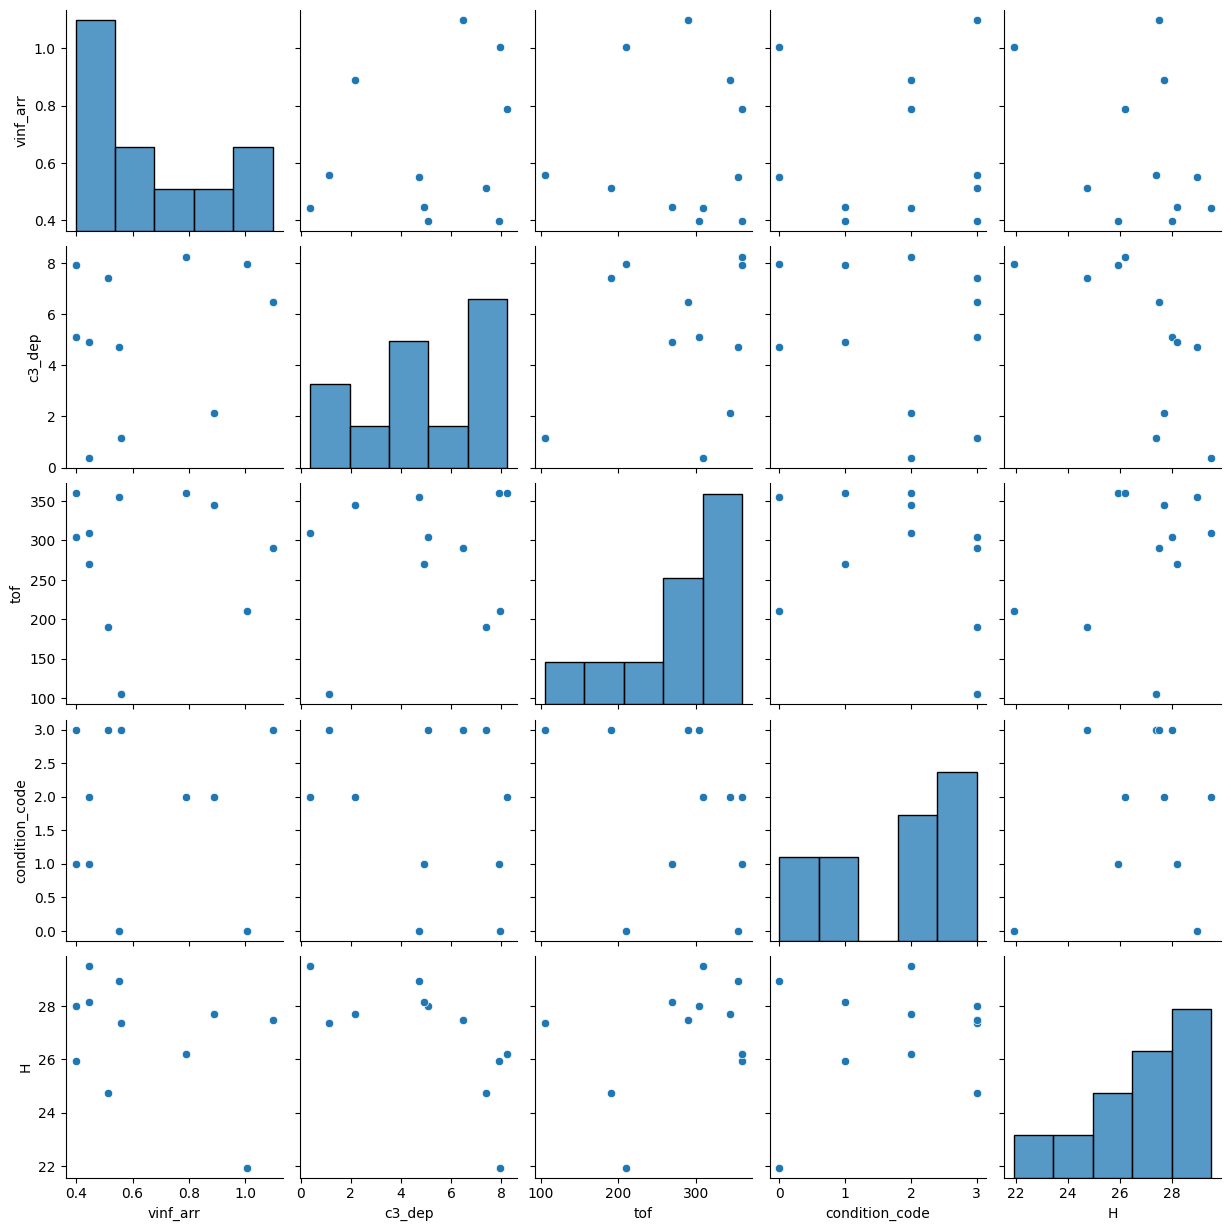

In [36]:
plot_asteroid_data(asteroid_data,scoring_criteria)

A review of the pair plot output doesn't seem to yield many insights. Even with an initial query limit of 10,000, only 11 targets made it past our selection filters. With so few potential targets, it is difficult to identify any significant relationships betwen the parameters. It seems like there may be some sort of inverse relationship between C3 and Absolute Magnitude, but it is difficult to draw conclusions from a small sample size.

However, there are several observations worth noting from the univariate distribution plots:
1. Most candidate targets feature minimal arrival dV
2. Most candidate targets feature near max allowable time of flight
3. Most candidate targets feature high absolute magnitude

# Scoring
With no readily identifiable relationships between evaluation metrics, we will need to establish scoring criteria to downselect a target. First we note that all evaluation criteria should be minimized. Minimized arrival dV means we need to carry less propellant. Minimized departure characteristic energy means higher launch vehicle payload capacity. Minimized time of flight means we arrive sooner. Minimized condition code means lower object orbit uncertainty. Minimized absolute magnitude means an object with higher luminosity which is easier to track.

To score each parameter for each candidate target, we will first normalize all the outputs. For every metric except absolute magnitude, we will normalze by the limit value noted in the exploratory data analysis section. Absolute magnitude does not have a limiit value, so we will normalize by the maximum value in the filtered dataset. By normalizing in this manner, values equal to 1 are the least optimum choice, while the selection becomes more optimal as the score trends toward 0.

Finally, we assign weights to each parameter. Initially, each primary evaluation criteria was given a weight of 25%, while the two secondary criteria were given weights of 12.5%. Recall, however, that we are statistically more likely to select a target with a minimal arrival dV and maximal time of flight and absolute magnitude. With this in mind, we will adjust the weights of these parameters. Since most candidate targets feature low dV anyway, we will lower its weight to 20% and consequently raise the weight for the time of flight to 30%. This will attempt to skew our selected target to a lower time of flight while still maintaining near minimum arrival dV. We will also raise the weight of the absolute magnitude to 15%. This will attempt to bias our selected target towards more luminous bodies. And to maintain a total weight = 100%, we will also have to lower the criteria for the condition code to 10%.

|Param|Weight,Initial|Weight,Final|
|--|--|--|
|Arrival dV|25%|20%|
|Characteristic Energy|25%|25%|
|Time of Flight|25%|30%|
|Condition Code|12.5%|10%|
|Absolute Magnitude|12.5%|15%|

In [37]:
target_asteroid,total_score = select_target(asteroid_data,scoring_criteria)
display(f'Target Asteroid: {target_asteroid}')
display(f'Total Score: {round(total_score,3)}')

'Target Asteroid: (2012 TF79)'

'Total Score: 0.455'

# Spacecraft Sizing
Now that our target has been selected, we will need to size our spacecraft to meet the required arrival dV. Our total spacecraft mass (and importantly our propellant mass) will be dictated by our target arrival dV, vehicle mass, and specific impulse (Isp). These parameters are all related to each other by the Rocket Equation:
$$
dV = I_{sp} * g_0 * ln\frac{m_0}{m_f}
$$

Rearranging to solve for total mass:

$$
m_0 = m_f*exp(\frac{dv}{g_0*I_{sp}})
$$

We will vary the vehicle dry mass and Isp per the limits in the run config, and evaluate the impacts to the total vehicle mass. First, let's extract the target arrival dV for our selected asteroid. We will also go ahead and extract the departure C3 for use later.

In [38]:
target_vinf_arr, target_c3 = asteroid_data.loc[asteroid_data['name'] == target_asteroid,['vinf_arr','c3_dep']].values[0,:]

display(f'Target arrival dV for {target_asteroid}: {target_vinf_arr} km/sec')
display(f'Target departure C3: {round(target_c3,3)} km^2/sec^@')

'Target arrival dV for (2012 TF79): 0.5572 km/sec'

'Target departure C3: 1.139 km^2/sec^@'

We'll pass in the arrival dV for our target asteroid into our plotting utility, and evaluate total mass with respect to dry mass and Isp. We'll also return a dataframe of these outputs in case they're needed again later.

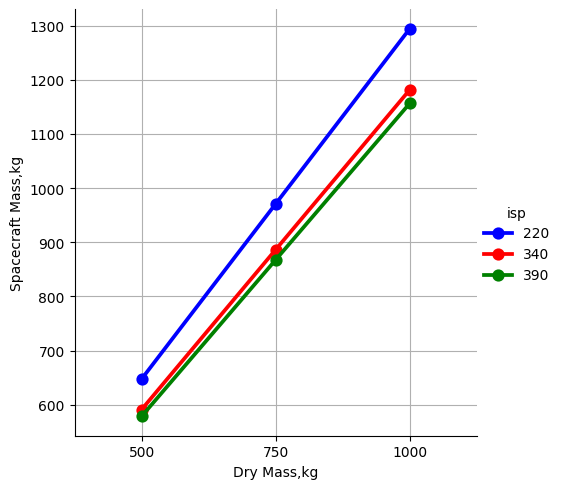

In [39]:
spacecraft_mass = evaluate_total_mass(target_vinf_arr,dry_mass_targs,isp_targs)


We only had a few mass and Isp targets to evaluate, so we can easily the relationship between total mass and dry mass and Isp with a simple line style categorical plot. We leverage seaborn to make this plot as it allows to group outputs with common inputs for easy visualization. Here we see that higher dry mass drives total spacecraft mass up, while higher Isp reduces spacecraft mass at any given dry mass target.

# Launch Vehicle Selection
Now that we understand our spacecraft mass requirements, we need to evaluate payload capacities of candidate launch vehicles. We are given the following data:

||C3 = 0|C3 = 5|C3 = 10|
|-|-|-|-|
|New Glenn|7300|6350|4900|
|Falcon Heavy|6800|5900|5200|
|Falcon 9 (ASDS)|3300|2700|2250|
|Vulcan (VC2)|5900|5250|4800|

We will read this data into a dataframe, stripping out the non-numeric data in the head for plotting and interpolation later.

In [40]:
vehicle_data = parse_vehicle_data(vehicle_data_path)
display(vehicle_data)

,0.0,5.0,10.0
New Glenn,7300,6350,4900
Falcon Heavy,6800,5900,5200
Falcon 9 (ASDS),3300,2700,2250
Vulcan (VC2),5900,5250,4800


# Payload Interpolation
With our vehcile data loaded in, we will now need to evaluate payload capacities at the target characteristic energy. First, for each vehicle we will interpolate its payload capacity at the input C3 condition. Numpy has built-in methods to accomplish this. Next, for each launch vehicle, we will plot payload capacity vs C3 as well as the interpolated payload mass for our target asteroid. Additionally, we will return a dictionary of payload capacities for each vehicle for later use.

We are using bokeh this time for plotting for it's interactive features, so we wil also need to call its output_notebook function to display it in Jupyter.

In [42]:
output_notebook()
payload_capacity = interpolate_payload_mass(vehicle_data,target_c3,fig_height=500,fig_width=500)
display(payload_capacity)

Loading BokehJS ...

{'New Glenn': 7083.5248756,
 'Falcon Heavy': 6594.9183032,
 'Falcon 9 (ASDS)': 3163.2788688,
 'Vulcan (VC2)': 5751.8854412}